In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm  
import torch
import torch.nn as nn
import snntorch as snn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
EPOCHS = 100 
LEARNING_RATE = 1e-4
BETA = 0.9
NUM_THRESHOLDS = 15
NUM_FEATURES = 40
NUM_HIDDEN = 256
NUM_OUTPUTS = 10
NUM_INPUTS = NUM_FEATURES * NUM_THRESHOLDS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def features_extractor_temporal(file_path, max_pad_len=174):
    """Extracts MFCCs and preserves the time dimension."""
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=NUM_FEATURES)
        
        if mfccs_features.shape[1] > max_pad_len:
            mfccs_features = mfccs_features[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs_features.shape[1]
            mfccs_features = np.pad(mfccs_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
            
        return mfccs_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [4]:
def encode_population_threshold(temporal_features, num_thresholds=NUM_THRESHOLDS):
    """Encodes temporal features into spike trains."""
    min_val, max_val = temporal_features.min(), temporal_features.max()
    if max_val > min_val:
        temporal_features = (temporal_features - min_val) / (max_val - min_val)
    
    num_features, num_timesteps = temporal_features.shape
    thresholds = np.linspace(0, 1, num_thresholds)
    
    total_neurons = num_features * num_thresholds
    spike_train = np.zeros((num_timesteps, total_neurons), dtype=np.float32)
    
    for t in range(num_timesteps):
        feature_vector_at_t = temporal_features[:, t]
        for f in range(num_features):
            neuron_spikes = (feature_vector_at_t[f] >= thresholds).astype(np.float32)
            start_index = f * num_thresholds
            end_index = start_index + num_thresholds
            spike_train[t, start_index:end_index] = neuron_spikes
            
    return spike_train

In [5]:
print("Loading metadata and processing audio files...")
audio_dataset_path = r'D:\Audio Classification\Data'
metadata = pd.read_csv(r'D:\Audio Classification\Data\UrbanSound8K.csv')

extracted_features = []
for index_num, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    
    temporal_mfccs = features_extractor_temporal(file_name)
    if temporal_mfccs is not None:
        spike_train = encode_population_threshold(temporal_mfccs)
        extracted_features.append([spike_train, final_class_labels])

print("Feature extraction and encoding complete.")


Loading metadata and processing audio files...


  0%|          | 0/8732 [00:00<?, ?it/s]

 41%|████      | 3554/8732 [02:40<03:56, 21.94it/s]d:\conda\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8323/8732 [06:05<00:14, 27.86it/s]d:\conda\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8327/8732 [06:05<00:13, 29.89it/s]d:\conda\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [06:23<00:00, 22.79it/s]

Feature extraction and encoding complete.


In [6]:
extracted_features

[[array([[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]], shape=(174, 600), dtype=float32),
  'dog_bark'],
 [array([[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 1., 0., ..., 0., 0., 0.],
         [1., 1., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]], shape=(174, 600), dtype=float32),
  'children_playing'],
 [array([[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]], shape=(174, 600), dtype=float32),
  'children_playing'],
 [array([[1., 0., 0., ..., 0., 0., 0.],
         [1., 1., 0., ..., 0., 0

In [7]:
X = [item[0] for item in extracted_features]
y_str = [item[1] for item in extracted_features]

le = LabelEncoder()
y = le.fit_transform(y_str)
np.save('classes.npy', le.classes_)
num_classes = len(le.classes_)

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

class SpikeTrainDataset(Dataset):
    def __init__(self, spike_data, labels):
        self.spike_data = spike_data
        self.labels = labels
    def __len__(self):
        return len(self.spike_data)
    def __getitem__(self, idx):
        spikes = torch.tensor(self.spike_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return spikes, label

train_loader = DataLoader(SpikeTrainDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SpikeTrainDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SpikeTrainDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created. Training set size: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

DataLoaders created. Training set size: 5238, Validation: 1747, Test: 1747


In [9]:
class SNNModel(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.dropout = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        spk1_rec = []
        spk2_rec = []
        x = x.permute(1, 0, 2)

        for step in range(x.size(0)):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_dropped = self.dropout(spk1)
            cur2 = self.fc2(spk1_dropped)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk1_rec.append(spk1_dropped)
            spk2_rec.append(spk2)
        
        return torch.stack(spk2_rec, dim=0), torch.stack(spk1_rec, dim=0)

In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [11]:
net = SNNModel(num_inputs=NUM_INPUTS, num_hidden=NUM_HIDDEN, num_outputs=num_classes, beta=BETA).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(output, targets):
    spike_counts = torch.sum(output, dim=0) 
    _, predicted = torch.max(spike_counts, 1)
    correct = (predicted == targets).sum().item()
    return correct

best_val_accuracy = 0
patience = 10
patience_counter = 0

for epoch in range(EPOCHS):
    net.train()
    train_loss, train_correct, total_samples = 0, 0, 0
    for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        spk_out, spk_hidden = net(data)
        
        spike_counts = torch.sum(spk_out, dim=0)
        loss_cls = criterion(spike_counts, targets)
        reg_loss = 1e-5 * torch.sum(spk_hidden)
        loss = loss_cls + reg_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += calculate_accuracy(spk_out, targets)
        total_samples += targets.size(0)

    train_accuracy = 100 * train_correct / total_samples
    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    net.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            data, targets = data.to(device), targets.to(device)
            spk_out, spk_hidden = net(data)

            spike_counts = torch.sum(spk_out, dim=0)
            loss_cls = criterion(spike_counts, targets)
            reg_loss = 1e-5 * spk_hidden.mean()
            loss = loss_cls + reg_loss

            val_loss += loss.item()
            val_correct += calculate_accuracy(spk_out, targets)
            val_total += targets.size(0)

    
    val_accuracy = 100 * val_correct / val_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(net.state_dict(), 'best_snn_model.pth')
        print(f"-> New best model saved with validation accuracy: {best_val_accuracy:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Validation accuracy has not improved for {patience} epochs. Stopping early.")
        break

print("Training finished.")

Epoch 1/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s]


Epoch 1: Train Loss: 6.4054, Train Accuracy: 12.77%


Epoch 1/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s]


Epoch 1: Validation Accuracy: 11.45%
-> New best model saved with validation accuracy: 11.45%


Epoch 2/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Epoch 2: Train Loss: 4.9869, Train Accuracy: 19.47%


Epoch 2/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 2: Validation Accuracy: 12.31%
-> New best model saved with validation accuracy: 12.31%


Epoch 3/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 3: Train Loss: 4.2518, Train Accuracy: 25.45%


Epoch 3/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch 3: Validation Accuracy: 11.79%


Epoch 4/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.10it/s]


Epoch 4: Train Loss: 3.8077, Train Accuracy: 30.28%


Epoch 4/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 4: Validation Accuracy: 14.14%
-> New best model saved with validation accuracy: 14.14%


Epoch 5/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Epoch 5: Train Loss: 3.5152, Train Accuracy: 34.02%


Epoch 5/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s]


Epoch 5: Validation Accuracy: 16.37%
-> New best model saved with validation accuracy: 16.37%


Epoch 6/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 6: Train Loss: 3.3220, Train Accuracy: 36.94%


Epoch 6/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 6: Validation Accuracy: 18.09%
-> New best model saved with validation accuracy: 18.09%


Epoch 7/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 7: Train Loss: 3.2284, Train Accuracy: 38.49%


Epoch 7/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s]


Epoch 7: Validation Accuracy: 19.98%
-> New best model saved with validation accuracy: 19.98%


Epoch 8/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 8: Train Loss: 3.1465, Train Accuracy: 41.45%


Epoch 8/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 8: Validation Accuracy: 17.12%


Epoch 9/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 9: Train Loss: 3.0834, Train Accuracy: 42.61%


Epoch 9/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 9: Validation Accuracy: 17.69%


Epoch 10/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 10: Train Loss: 3.0405, Train Accuracy: 43.47%


Epoch 10/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 10: Validation Accuracy: 22.10%
-> New best model saved with validation accuracy: 22.10%


Epoch 11/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 11: Train Loss: 2.9753, Train Accuracy: 46.12%


Epoch 11/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 11: Validation Accuracy: 19.98%


Epoch 12/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 12: Train Loss: 2.9483, Train Accuracy: 46.28%


Epoch 12/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch 12: Validation Accuracy: 28.39%
-> New best model saved with validation accuracy: 28.39%


Epoch 13/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 13: Train Loss: 2.9338, Train Accuracy: 45.86%


Epoch 13/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 13: Validation Accuracy: 30.51%
-> New best model saved with validation accuracy: 30.51%


Epoch 14/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 14: Train Loss: 2.8575, Train Accuracy: 48.47%


Epoch 14/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch 14: Validation Accuracy: 22.95%


Epoch 15/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 15: Train Loss: 2.8241, Train Accuracy: 48.72%


Epoch 15/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch 15: Validation Accuracy: 29.36%


Epoch 16/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 16: Train Loss: 2.7549, Train Accuracy: 50.21%


Epoch 16/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 16: Validation Accuracy: 30.74%
-> New best model saved with validation accuracy: 30.74%


Epoch 17/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 17: Train Loss: 2.7234, Train Accuracy: 50.23%


Epoch 17/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 17: Validation Accuracy: 31.31%
-> New best model saved with validation accuracy: 31.31%


Epoch 18/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 18: Train Loss: 2.7063, Train Accuracy: 50.65%


Epoch 18/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.74it/s]


Epoch 18: Validation Accuracy: 30.45%


Epoch 19/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Epoch 19: Train Loss: 2.6439, Train Accuracy: 51.64%


Epoch 19/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 19: Validation Accuracy: 31.94%
-> New best model saved with validation accuracy: 31.94%


Epoch 20/100 [Training]: 100%|██████████| 164/164 [01:15<00:00,  2.16it/s]


Epoch 20: Train Loss: 2.6481, Train Accuracy: 51.83%


Epoch 20/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch 20: Validation Accuracy: 32.51%
-> New best model saved with validation accuracy: 32.51%


Epoch 21/100 [Training]: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch 21: Train Loss: 2.6291, Train Accuracy: 51.36%


Epoch 21/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 21: Validation Accuracy: 31.31%


Epoch 22/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 22: Train Loss: 2.5664, Train Accuracy: 53.07%


Epoch 22/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch 22: Validation Accuracy: 34.00%
-> New best model saved with validation accuracy: 34.00%


Epoch 23/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 23: Train Loss: 2.5137, Train Accuracy: 53.67%


Epoch 23/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.20it/s]


Epoch 23: Validation Accuracy: 39.21%
-> New best model saved with validation accuracy: 39.21%


Epoch 24/100 [Training]: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s]


Epoch 24: Train Loss: 2.4845, Train Accuracy: 54.94%


Epoch 24/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 24: Validation Accuracy: 39.04%


Epoch 25/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 25: Train Loss: 2.4517, Train Accuracy: 54.96%


Epoch 25/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch 25: Validation Accuracy: 40.81%
-> New best model saved with validation accuracy: 40.81%


Epoch 26/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 26: Train Loss: 2.4362, Train Accuracy: 54.91%


Epoch 26/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 26: Validation Accuracy: 38.87%


Epoch 27/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 27: Train Loss: 2.4052, Train Accuracy: 56.43%


Epoch 27/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch 27: Validation Accuracy: 41.96%
-> New best model saved with validation accuracy: 41.96%


Epoch 28/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 28: Train Loss: 2.4121, Train Accuracy: 55.06%


Epoch 28/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch 28: Validation Accuracy: 44.25%
-> New best model saved with validation accuracy: 44.25%


Epoch 29/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Epoch 29: Train Loss: 2.3415, Train Accuracy: 56.43%


Epoch 29/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch 29: Validation Accuracy: 43.79%


Epoch 30/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 30: Train Loss: 2.3174, Train Accuracy: 57.35%


Epoch 30/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 30: Validation Accuracy: 41.10%


Epoch 31/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 31: Train Loss: 2.3002, Train Accuracy: 56.62%


Epoch 31/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s]


Epoch 31: Validation Accuracy: 41.61%


Epoch 32/100 [Training]: 100%|██████████| 164/164 [01:19<00:00,  2.07it/s]


Epoch 32: Train Loss: 2.2372, Train Accuracy: 58.72%


Epoch 32/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch 32: Validation Accuracy: 45.33%
-> New best model saved with validation accuracy: 45.33%


Epoch 33/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s]


Epoch 33: Train Loss: 2.2406, Train Accuracy: 57.90%


Epoch 33/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s]


Epoch 33: Validation Accuracy: 40.81%


Epoch 34/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 34: Train Loss: 2.2321, Train Accuracy: 57.90%


Epoch 34/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 34: Validation Accuracy: 53.86%
-> New best model saved with validation accuracy: 53.86%


Epoch 35/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 35: Train Loss: 2.2025, Train Accuracy: 59.07%


Epoch 35/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 35: Validation Accuracy: 53.35%


Epoch 36/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 36: Train Loss: 2.1834, Train Accuracy: 59.39%


Epoch 36/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 36: Validation Accuracy: 48.54%


Epoch 37/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 37: Train Loss: 2.1680, Train Accuracy: 59.24%


Epoch 37/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 37: Validation Accuracy: 49.17%


Epoch 38/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s]


Epoch 38: Train Loss: 2.1563, Train Accuracy: 60.50%


Epoch 38/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.93it/s]


Epoch 38: Validation Accuracy: 49.74%


Epoch 39/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Epoch 39: Train Loss: 2.1202, Train Accuracy: 60.65%


Epoch 39/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 39: Validation Accuracy: 54.55%
-> New best model saved with validation accuracy: 54.55%


Epoch 40/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 40: Train Loss: 2.1379, Train Accuracy: 60.14%


Epoch 40/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s]


Epoch 40: Validation Accuracy: 53.69%


Epoch 41/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 41: Train Loss: 2.0867, Train Accuracy: 61.21%


Epoch 41/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch 41: Validation Accuracy: 51.63%


Epoch 42/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 42: Train Loss: 2.0555, Train Accuracy: 61.72%


Epoch 42/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s]


Epoch 42: Validation Accuracy: 54.26%


Epoch 43/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Epoch 43: Train Loss: 2.0631, Train Accuracy: 61.40%


Epoch 43/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch 43: Validation Accuracy: 50.03%


Epoch 44/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 44: Train Loss: 2.0175, Train Accuracy: 62.18%


Epoch 44/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch 44: Validation Accuracy: 55.07%
-> New best model saved with validation accuracy: 55.07%


Epoch 45/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.10it/s]


Epoch 45: Train Loss: 1.9982, Train Accuracy: 62.71%


Epoch 45/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch 45: Validation Accuracy: 57.30%
-> New best model saved with validation accuracy: 57.30%


Epoch 46/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Epoch 46: Train Loss: 1.9724, Train Accuracy: 63.34%


Epoch 46/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s]


Epoch 46: Validation Accuracy: 54.61%


Epoch 47/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s]


Epoch 47: Train Loss: 1.9734, Train Accuracy: 62.41%


Epoch 47/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch 47: Validation Accuracy: 53.92%


Epoch 48/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 48: Train Loss: 1.9572, Train Accuracy: 63.00%


Epoch 48/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s]


Epoch 48: Validation Accuracy: 56.04%


Epoch 49/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 49: Train Loss: 1.9658, Train Accuracy: 62.92%


Epoch 49/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s]


Epoch 49: Validation Accuracy: 59.02%
-> New best model saved with validation accuracy: 59.02%


Epoch 50/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 50: Train Loss: 1.9388, Train Accuracy: 63.82%


Epoch 50/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s]


Epoch 50: Validation Accuracy: 55.07%


Epoch 51/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.13it/s]


Epoch 51: Train Loss: 1.8945, Train Accuracy: 64.07%


Epoch 51/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch 51: Validation Accuracy: 56.61%


Epoch 52/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.11it/s]


Epoch 52: Train Loss: 1.9090, Train Accuracy: 63.99%


Epoch 52/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s]


Epoch 52: Validation Accuracy: 55.07%


Epoch 53/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 53: Train Loss: 1.8650, Train Accuracy: 63.36%


Epoch 53/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch 53: Validation Accuracy: 56.21%


Epoch 54/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 54: Train Loss: 1.8712, Train Accuracy: 64.83%


Epoch 54/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s]


Epoch 54: Validation Accuracy: 61.08%
-> New best model saved with validation accuracy: 61.08%


Epoch 55/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.13it/s]


Epoch 55: Train Loss: 1.8824, Train Accuracy: 64.85%


Epoch 55/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s]


Epoch 55: Validation Accuracy: 58.33%


Epoch 56/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.16it/s]


Epoch 56: Train Loss: 1.8402, Train Accuracy: 65.16%


Epoch 56/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 56: Validation Accuracy: 62.97%
-> New best model saved with validation accuracy: 62.97%


Epoch 57/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 57: Train Loss: 1.8632, Train Accuracy: 63.88%


Epoch 57/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.08it/s]


Epoch 57: Validation Accuracy: 57.58%


Epoch 58/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.14it/s]


Epoch 58: Train Loss: 1.8411, Train Accuracy: 65.20%


Epoch 58/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.92it/s]


Epoch 58: Validation Accuracy: 61.08%


Epoch 59/100 [Training]: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s]


Epoch 59: Train Loss: 1.8063, Train Accuracy: 65.81%


Epoch 59/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


Epoch 59: Validation Accuracy: 61.13%


Epoch 60/100 [Training]: 100%|██████████| 164/164 [01:22<00:00,  2.00it/s]


Epoch 60: Train Loss: 1.7800, Train Accuracy: 66.11%


Epoch 60/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.67it/s]


Epoch 60: Validation Accuracy: 63.14%
-> New best model saved with validation accuracy: 63.14%


Epoch 61/100 [Training]: 100%|██████████| 164/164 [01:22<00:00,  1.99it/s]


Epoch 61: Train Loss: 1.8155, Train Accuracy: 65.54%


Epoch 61/100 [Validation]: 100%|██████████| 55/55 [00:15<00:00,  3.65it/s]


Epoch 61: Validation Accuracy: 62.68%


Epoch 62/100 [Training]: 100%|██████████| 164/164 [01:20<00:00,  2.04it/s]


Epoch 62: Train Loss: 1.7972, Train Accuracy: 65.60%


Epoch 62/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s]


Epoch 62: Validation Accuracy: 62.05%


Epoch 63/100 [Training]: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch 63: Train Loss: 1.8039, Train Accuracy: 65.92%


Epoch 63/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s]


Epoch 63: Validation Accuracy: 62.11%


Epoch 64/100 [Training]: 100%|██████████| 164/164 [01:15<00:00,  2.17it/s]


Epoch 64: Train Loss: 1.7981, Train Accuracy: 65.81%


Epoch 64/100 [Validation]: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s]


Epoch 64: Validation Accuracy: 61.88%


Epoch 65/100 [Training]: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


Epoch 65: Train Loss: 1.7351, Train Accuracy: 67.98%


Epoch 65/100 [Validation]: 100%|██████████| 55/55 [00:15<00:00,  3.65it/s]


Epoch 65: Validation Accuracy: 62.91%


Epoch 66/100 [Training]: 100%|██████████| 164/164 [01:17<00:00,  2.12it/s]


Epoch 66: Train Loss: 1.7829, Train Accuracy: 65.71%


Epoch 66/100 [Validation]: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


Epoch 66: Validation Accuracy: 65.31%
-> New best model saved with validation accuracy: 65.31%


Epoch 67/100 [Training]: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


Epoch 67: Train Loss: 1.7420, Train Accuracy: 67.26%


Epoch 67/100 [Validation]: 100%|██████████| 55/55 [00:19<00:00,  2.79it/s]


Epoch 67: Validation Accuracy: 62.85%


Epoch 68/100 [Training]: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


Epoch 68: Train Loss: 1.7326, Train Accuracy: 68.25%


Epoch 68/100 [Validation]: 100%|██████████| 55/55 [00:20<00:00,  2.70it/s]


Epoch 68: Validation Accuracy: 61.82%


Epoch 69/100 [Training]: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


Epoch 69: Train Loss: 1.7362, Train Accuracy: 66.95%


Epoch 69/100 [Validation]: 100%|██████████| 55/55 [00:19<00:00,  2.77it/s]


Epoch 69: Validation Accuracy: 62.34%


Epoch 70/100 [Training]: 100%|██████████| 164/164 [01:52<00:00,  1.45it/s]


Epoch 70: Train Loss: 1.6910, Train Accuracy: 68.12%


Epoch 70/100 [Validation]: 100%|██████████| 55/55 [00:21<00:00,  2.58it/s]


Epoch 70: Validation Accuracy: 64.05%


Epoch 71/100 [Training]: 100%|██████████| 164/164 [01:54<00:00,  1.43it/s]


Epoch 71: Train Loss: 1.6704, Train Accuracy: 67.37%


Epoch 71/100 [Validation]: 100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


Epoch 71: Validation Accuracy: 63.88%


Epoch 72/100 [Training]: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


Epoch 72: Train Loss: 1.6893, Train Accuracy: 67.72%


Epoch 72/100 [Validation]: 100%|██████████| 55/55 [00:18<00:00,  2.92it/s]


Epoch 72: Validation Accuracy: 64.34%


Epoch 73/100 [Training]: 100%|██████████| 164/164 [01:53<00:00,  1.45it/s]


Epoch 73: Train Loss: 1.6603, Train Accuracy: 68.14%


Epoch 73/100 [Validation]: 100%|██████████| 55/55 [00:20<00:00,  2.74it/s]


Epoch 73: Validation Accuracy: 64.57%


Epoch 74/100 [Training]: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


Epoch 74: Train Loss: 1.6908, Train Accuracy: 67.43%


Epoch 74/100 [Validation]: 100%|██████████| 55/55 [00:19<00:00,  2.77it/s]


Epoch 74: Validation Accuracy: 61.76%


Epoch 75/100 [Training]: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


Epoch 75: Train Loss: 1.6121, Train Accuracy: 68.48%


Epoch 75/100 [Validation]: 100%|██████████| 55/55 [00:20<00:00,  2.72it/s]


Epoch 75: Validation Accuracy: 65.25%


Epoch 76/100 [Training]: 100%|██████████| 164/164 [01:52<00:00,  1.45it/s]


Epoch 76: Train Loss: 1.6123, Train Accuracy: 68.37%


Epoch 76/100 [Validation]: 100%|██████████| 55/55 [00:20<00:00,  2.71it/s]

Epoch 76: Validation Accuracy: 62.68%
Validation accuracy has not improved for 10 epochs. Stopping early.
Training finished.


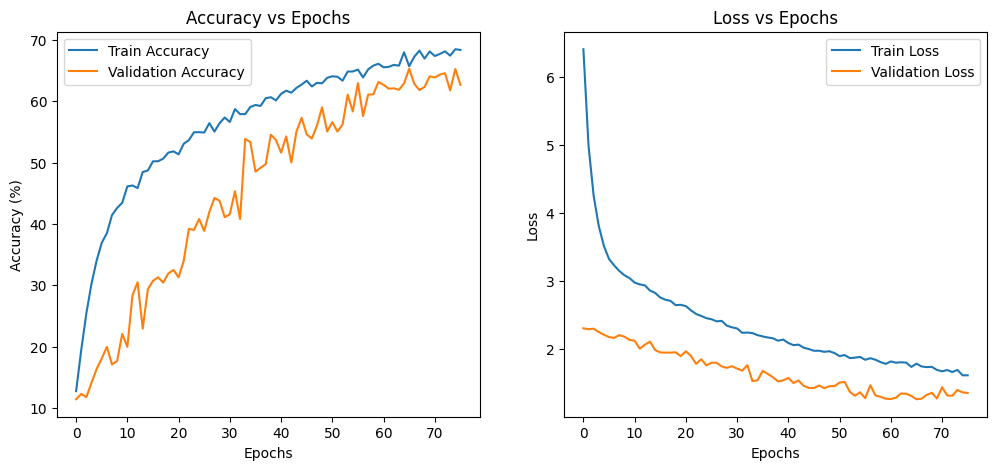

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.show()


In [13]:
print("\n--- Final Evaluation on Test Set ---")
net.load_state_dict(torch.load('best_snn_model.pth'))
net.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Final Test"):
        data, targets = data.to(device), targets.to(device)
        spk_out, _ = net(data)
        test_correct += calculate_accuracy(spk_out, targets)
        test_total += targets.size(0)
        
test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy on the best model: {test_accuracy:.2f}%")


--- Final Evaluation on Test Set ---


Final Test:   0%|          | 0/55 [00:00<?, ?it/s]

Final Test: 100%|██████████| 55/55 [00:22<00:00,  2.46it/s]

Final Test Accuracy on the best model: 63.19%


<Figure size 800x600 with 0 Axes>

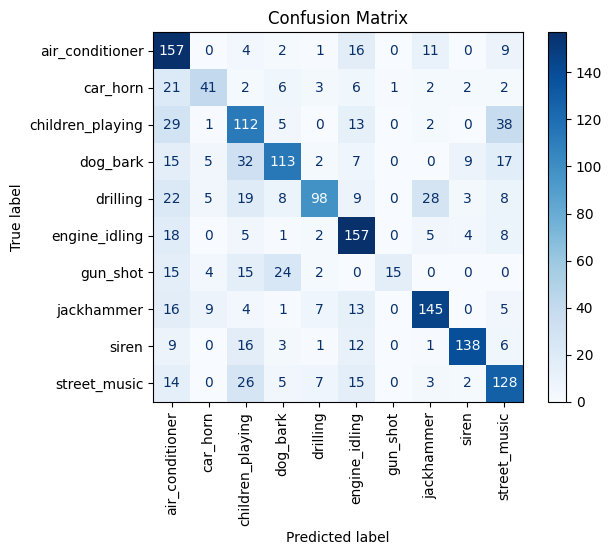

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
net.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        spk_out, _ = net(data)
        spike_counts = torch.sum(spk_out, dim=0)
        _, predicted = torch.max(spike_counts, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

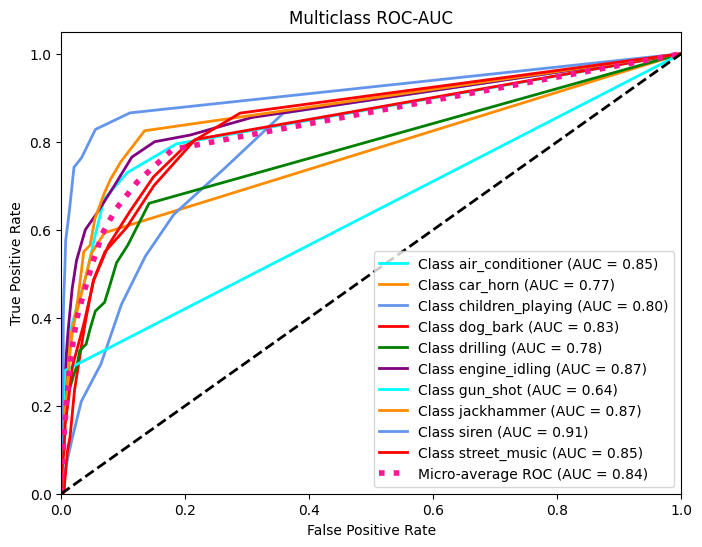

Macro ROC-AUC: 0.8167703355775616
Micro ROC-AUC: 0.8374192394437747


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_true = []
y_scores = []

net.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        spk_out, _ = net(data)
        spike_counts = torch.sum(spk_out, dim=0) 
        y_true.extend(targets.cpu().numpy())
        y_scores.extend(spike_counts.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(8,6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC-AUC")
plt.legend(loc="lower right")
plt.show()

print("Macro ROC-AUC:", roc_auc_score(y_true_bin, y_scores, average="macro"))
print("Micro ROC-AUC:", roc_auc_score(y_true_bin, y_scores, average="micro"))
